# Template for multi-pitch detection TP

*(reference: Klapuri) but with pitch detection with spectral sum

*From G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

### Notes: This notebook is adapted to be used with Colab 21 Mar 2022. 
**Python version: 3.7.12** 

In [148]:
# Adapt pyaudio with python 3.7.12 of Colab
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install pyaudio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [149]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
import IPython
import librosa

colab = True

Load drive

In [150]:
if colab:
    from google.colab import drive
    mnt_point ='/content/drive/'
    drive.mount(mnt_point)
    DIR = mnt_point + 'MyDrive/_sound/multipitch/'
else:
    DIR = os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Functions

In [151]:
def load_music(file):
    return wave.open(file, 'rb')

#Cannot work with colab - "cannot find default output device"
# def play_music(file, chunk = 1024):
#     """
#     Script from PyAudio doc
#     """
#     wf = load_music(file)
#     p = pyaudio.PyAudio()
#     stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
#                     channels=wf.getnchannels(),
#                     rate=wf.getframerate(),
#                     output=True)
#     data = wf.readframes(chunk)

#     while data:
#         stream.write(data)
#         data = wf.readframes(chunk )

#     stream.stop_stream()
#     stream.close()
#     p.terminate()

def play_music(file):
    #audio, sr_hz = librosa.load(file, sr=None)
    wavefile = load_music(file)
    nb_frames = wavefile.getnframes()
    sr_hz = wavefile.getframerate()
    audio = wavefile.readframes(nb_frames)
    audio_int_16 = np.frombuffer(audio, dtype=np.int16)
    audio = audio_int_16.astype(np.float32)
    IPython.display.display(IPython.display.Audio(audio, rate = sr_hz))
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_


def f2idx(F, df):
    """
    Convert frequency to corresponding index in "frequencies" array
    """
    return ceil(F/df)

## 0 - Reading and playing .wav file

Choose the name of music for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [152]:
current_path = os.getcwd()
if colab:
    data_path = DIR
else:
    data_path = os.path.join(current_path, 'sons_multipitch')

filename = 'A4_piano.wav'
music = os.path.join(data_path, filename) 

### **Using wave**

In [153]:
wavefile = load_music(music)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=31994, comptype='NONE', compname='not compressed')


In [154]:
play = True
if play :
    play_music(music) 

In [155]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [156]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

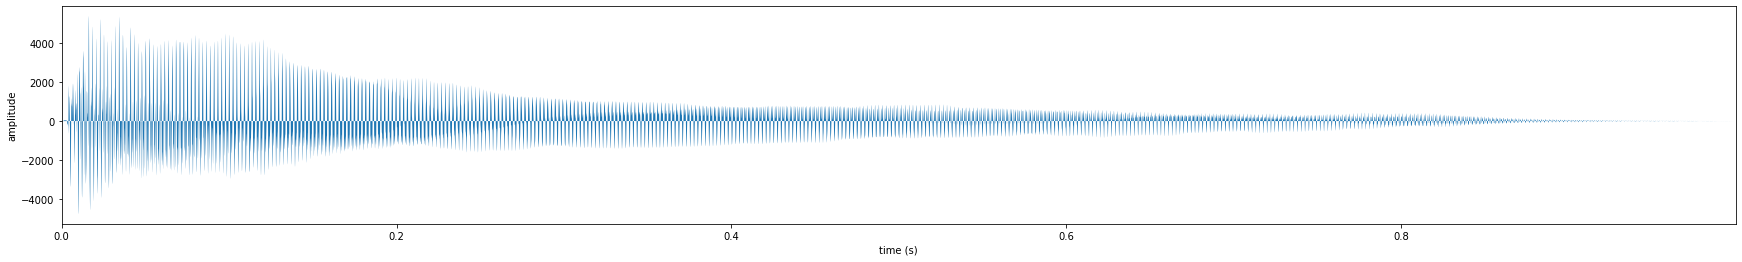

In [157]:
plot_sound(x, times)

## I - Window and Fast Fourier Transform


**1. Window size :** A Hamming window is used, its length covering $700$ ms of the entire signal 

**2. Offset :** The offset is chosen to be about $100$ ms, 

**3. Spectral precision after the FFT :** The frequency precision is given by $dF_{\text{min}}=\frac{F_{s}}{Nfft}$, where $Nfft$ is the size of the FFT window. 


<div class="alert alert-success">

## Answer questions:
1. Window size is the size that we will for each frame in Short-Time Fourier Transform. This size is chosen so that the property of sound in this window is stable or change not much. We can see in the graph that 700 ms is will cover the main part of our sound which contains the notes.
2. The offset setting will place us in to the stable part of the sound. The beginning of the sound is not stable when the notes are not yet well confusioned (freshly played).
3. The precision is  $dF_{\text{min}}=\frac{F_{s}}{Nfft}$ or 1.43 Hz in our case. It's appropriate because the pitch peak is around 6 Hz.

In [158]:
N=ceil(0.7*Fs)       # Window size of analysed signal (only one window of signal is analysed)
dF_min=Fs/N   # Minimal frequency resolution
print('The minimal frequency resolution is of {:.2f} Hz'.format(dF_min))

The minimal frequency resolution is of 1.43 Hz


In [159]:
w=np.hamming(N)  # Window
width = 4*dF_min # largeur du pic spectral (en Hz) 4*dF_min
eps=float(1e-20)   #precision

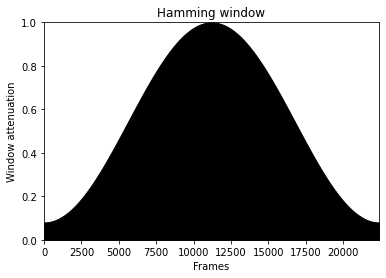

In [160]:
plt.fill_between(np.arange(len(w)), w, color='k')
plt.title('Hamming window')
plt.xlabel('Frames')
plt.ylabel('Window attenuation')
plt.xlim(0, len(w))
plt.ylim(0, 1)
plt.show()

### Discarding the attack of the sound

In [161]:
offset=ceil(0.1*Fs)
xw=x[offset:offset+N]*w    # xw is the analysed signal frame
n_xw = xw.size

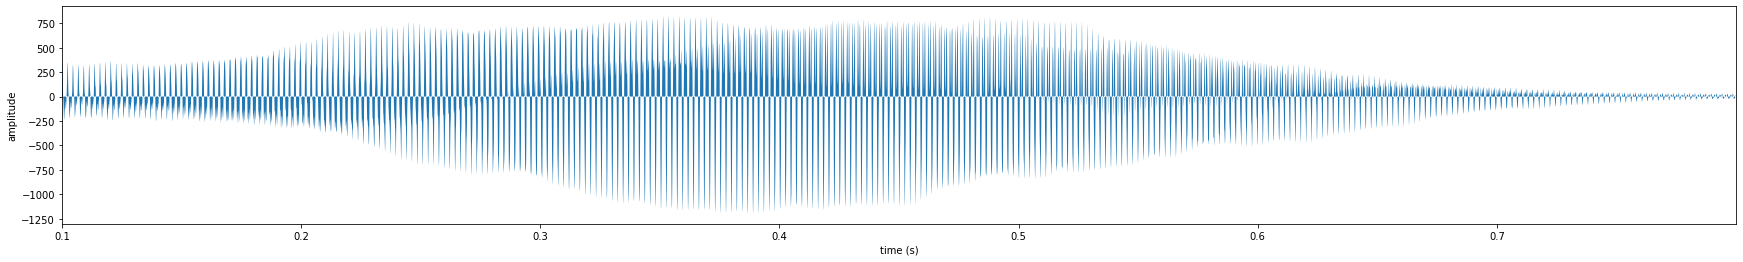

In [162]:
plot_sound(xw, times[offset:offset+N])

This is the temporal visualization of the sound we will be working on.

### Processing for efficient FFT (*by truncating to powers of 2*)

In [163]:
#Minimal number of data points to satisfy the minimal frequency resolution
Nfft_min=Fs/dF_min

#compute the smallest power of two that satisfies the minimal frequency resolution for FFT
p, Nfft = nextpow2(Nfft_min)
x_fft = np.fft.fft(xw, n=Nfft) #calcul FFT
x_fft /= np.max(np.abs(x_fft))+eps # Normalization

df=Fs/Nfft # frequency virtual resolution of FFT 
print('Frequency virtual resolution of FFT {:.2} Hz'.format(df))

Frequency virtual resolution of FFT 0.98 Hz


In [164]:
frequencies = np.arange(Nfft)*df  # equivalent to np.fft.fftfreq(n=Nfft, d=timestep)
X_fft = np.abs(x_fft) # absolute value of FFT (phase doesn't play a role)

<div class="alert alert-success">
N_fft min will be $\frac{Fs}{dF_{min}}$

Plot FFT spectrum

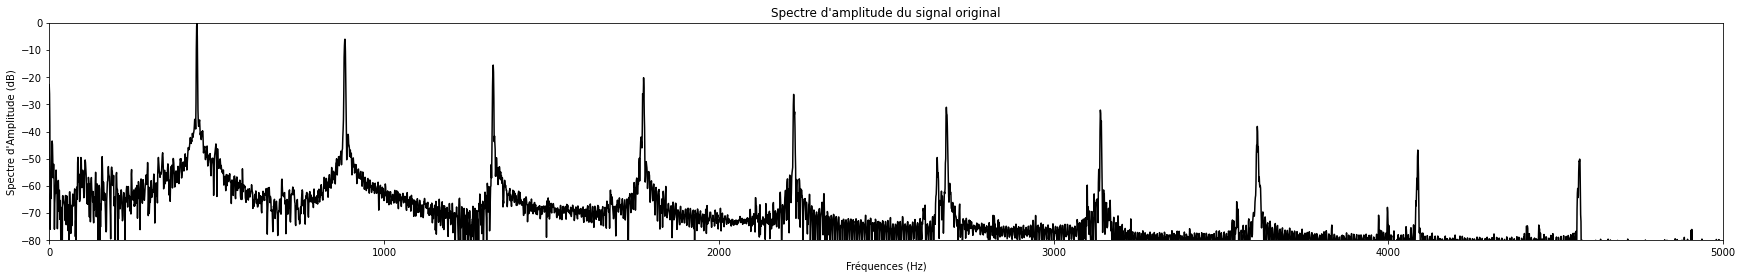

In [165]:
plt.figure(figsize=(30, 4))
plt.plot(frequencies[:int(Nfft/2)], 20*np.log10(X_fft[:int(Nfft/2)]), color='k')
plt.xlim(0, 5000)
plt.ylim(-80, 0)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title('Spectre d\'amplitude du signal original')
plt.show()

For **A4_piano.wav**, we clearly see the harmonic around $\sim 440$ Hz and partials (multiples of the fundamental frequency peak).

## II - Fundamental frequency estimation by spectral product/sum method

The different steps include :

#loop on the number of pitches
    - example criterion could use an energy ratio "while criterion > seuil_F0"
    
  #Detection of main F0
  
        -Compute spectral sum
        -locate maximum
        -store value of estimated F0

  #Subtraction of main note (Main F0 with its harmonics)
        
        -localisation of harmonics around theoretical values (with or without inharmonicy coefficient) 
        - beta: harmonicity coefficient ;  alpha: coefficient of tolerance
                
        - Harmonic suppression (wideness of an harmonic to be suppressed depends on the main lob of the TF of the analysis window); suppression of harmonics is done on abs(Xk) on forcing all values of a harmonic peak to the minimum value of the peak (e.g. the level of noise).
         
#end of loop

In [166]:
Fmin=100             # Minimal F0 frequency that can be detected
Fmax=900             # Maximal F0 frequency that can be detected
H=4                  # H = nombre de versions compressées
Rmax = ceil((Nfft-1)/(2*H)) # fréquence maximale

In [167]:
Nmin = f2idx(Fmin,df)-1
Nmax = f2idx(Fmax,df)
assert Nmax <= Rmax and Nmin >= 0

<div class="alert alert-success">


## Answer Questions:
- Fmax will be 900 Hz
- Then Rmax will be ceil((Nfft-1)/(2*H)).

Functions sum and product

In [168]:
def concentrate_spectrum(x, R, h):
    h = int(h)
    r = np.zeros(R)
    for i in range(R):
        for j in range(h):
            r[i] = r[i] + x[h*i+j]
        r[i] = r[i]*1.0/h
    return r

def spectral_prod(x, R, H):
    """
    Spectral Product
    """
    modules = np.zeros((H,R))
    #fourier = 20*np.log10(x[:int(Nfft/2)])
    for h in range(1, H+1):
        modules[h-1] = concentrate_spectrum(x, R, h)
    return np.prod(modules, axis=0)


def spectral_sum(x, R, H):
    """
    Spectral sum
    """
    modules = np.zeros((H,R))
    #fourier = 20*np.log10(x[:int(Nfft/2)])
    for h in range(1, H+1):
        modules[h-1] = concentrate_spectrum(x, R, h)
    return np.sum(modules, axis=0)


def spectral_method(x, R, H, method='product'):
    """
    Factorization of previous methods
    """
    assert method in ['sum', 'product']
    if method == 'sum':
        return spectral_sum(x, R, H)
    else:
        return spectral_prod(x, R, H)

Fundamental frequency Search

In [169]:
method = 'product'
freq = frequencies[:int(Nfft/2)]
fourier = 20*np.log10(X_fft[:int(Nfft/2)])
P = spectral_method(fourier, Rmax, H, method)

In [170]:
def get_F0(freq, spectral_method, H, R, Fmin, Fmax, method="product", plot=True):
    
    if plot:
        plt.figure(figsize=(30, 4))
        plt.plot(freq[:R], spectral_method, color='k')
        plt.xlim(Fmin, Fmax)
        #plt.ylim(-80, 0)
        plt.xlabel('Frequencies (Hz)')
        plt.ylabel('Amplitude(dB)')
        plt.title('Spectral')
        plt.show()
    
    ind_min = len(freq[freq<Fmin])
    ind_max = len(freq[freq<Fmax])
    
    if method == "product":
        return freq[np.argmin(spectral_method[ind_min:ind_max])+ind_min], np.argmin(spectral_method[ind_min:ind_max])+ind_min
    else:
        return freq[np.argmax(spectral_method[ind_min:ind_max])+ind_min], np.argmax(spectral_method[ind_min:ind_max])+ind_min

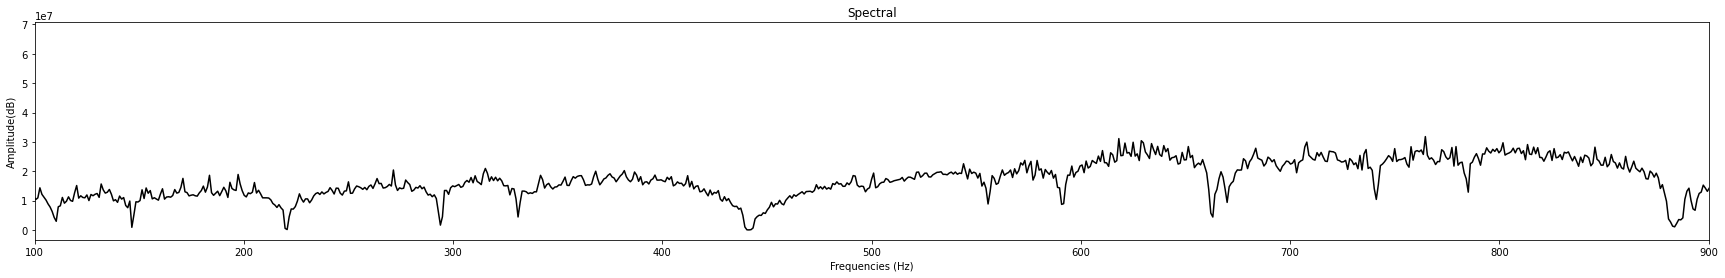

The fundamental freq of the sound is 441.41 ± 1.43 Hz


In [171]:
# Now we get the fundamental freq of sound
f0, idx_f0= get_F0(freq, P, H, Rmax, Fmin, Fmax, method)
print(f"The fundamental freq of the sound is {f0:.5} ± {dF_min:.3} Hz")

## 3.Subtraction of the harmonics of detected fundamental freq.

### 3.1 Harmonics detection

<div class="alert alert-success">

## Answer Question:
1. We search the k-th harmonic of the detected freq in the range $f_{kmin} = (1 - \alpha)*f_k$ and $f_{kmax} = (1 + \alpha)*f_k$. The good choice of $\alpha$ is $2^{1/12}$, corresponds to a semitone.

2. This search method will not be appropriate for the instruments have inharmonicity effect, such as piano.

### 3.2 Harmonics supression

In [172]:
def harmonic_supression(freq, fourier, idx_note, width, plot=True):
    
    max_idx = idx_note + len(freq[freq<width]) + 2
    min_idx = idx_note - len(freq[freq<width]) - 2
    #fourier = 20*np.log10(x[:int(Nfft/2)])
    if fourier[max_idx]<fourier[min_idx]:
        delta = max_idx - idx_note
        freq_in_delta = fourier[max_idx]
    else:
        delta = idx_note - min_idx
        freq_in_delta = fourier[min_idx]

    count = idx_note - delta
    while count < idx_note + delta:
        fourier[count] = freq_in_delta
        count += 1
    
    if plot:
        plt.figure(figsize=(30, 4))
        plt.plot(freq, fourier, color='k')
        plt.xlim(0, 5000)
        plt.ylim(-80, 0)
        plt.xlabel('Freq (Hz)')
        plt.ylabel('Spectral (dB)')
        plt.title('Harmonic supressed spectrum')
        plt.show()    
    
    return freq, fourier

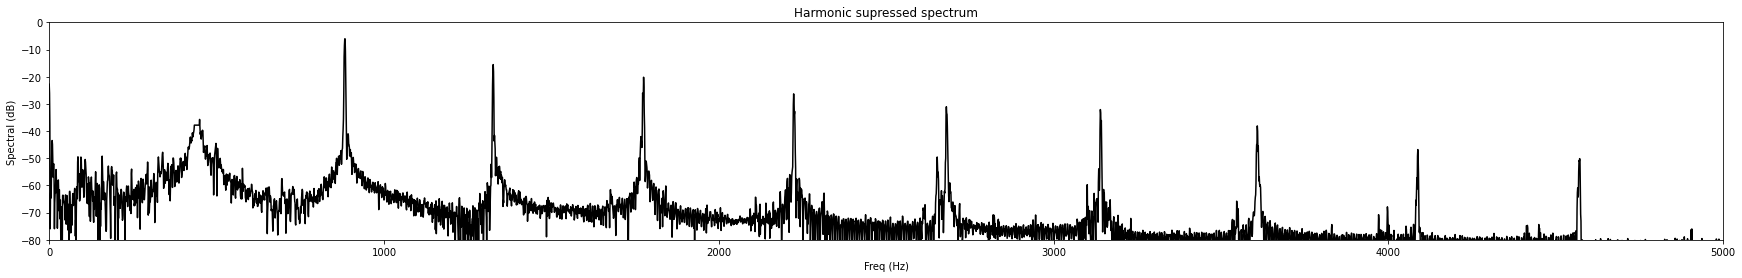

In [173]:
modified_freq, modified_fourier = harmonic_supression(freq, fourier, idx_f0, width)

## Below we delete all the harmonics of a note in the sound.

In [174]:
def note_supression(freq, fourier, idx_note, f0, width, plot=True):
    count = 2
    freq_study = count*f0
    center_idx = ceil(freq_study/(freq[1]-freq[0]))
    
    semitone_above = f0*2**(1/12)
    alpha = semitone_above - f0
    alpha_idx = 2*len(freq[freq<alpha])
    
    while freq_study < 15000 and center_idx < len(freq):
        if center_idx-alpha_idx<0:
            current_idx = np.argmax(fourier[0:center_idx+alpha_idx])
        else:
            current_idx = np.argmax(fourier[center_idx-alpha_idx:center_idx+alpha_idx]) + center_idx-alpha_idx
        freq, fourier = harmonic_supression(freq, fourier, current_idx, width, plot)
        
        count += 1
        freq_study = count*f0 
        center_idx = ceil(freq_study/(freq[1]-freq[0]))
        
    return freq, fourier

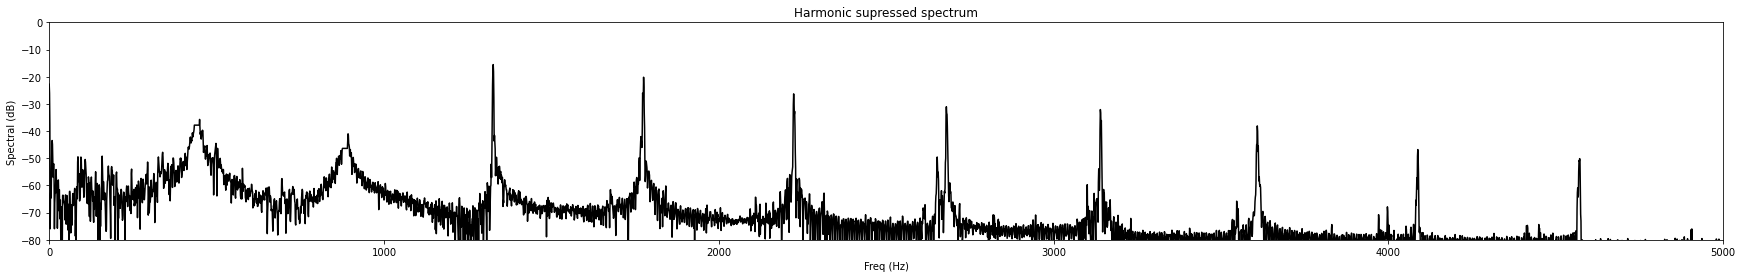

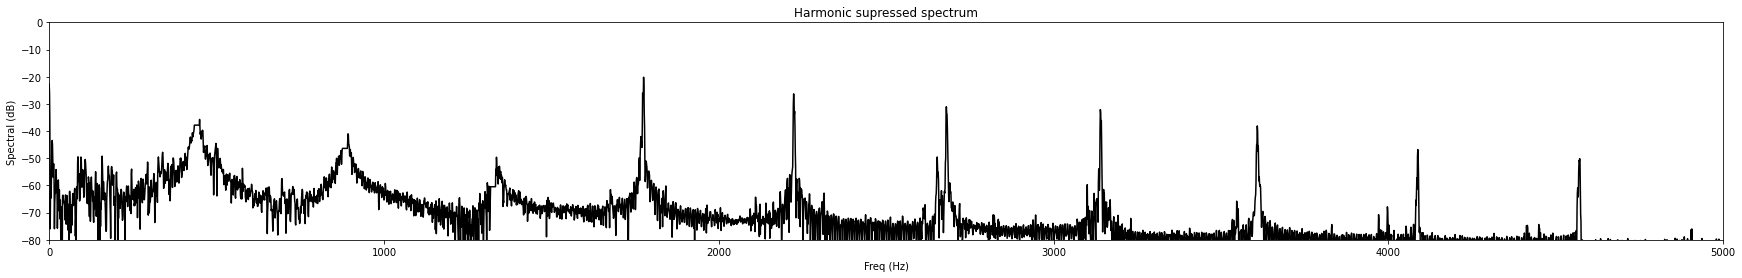

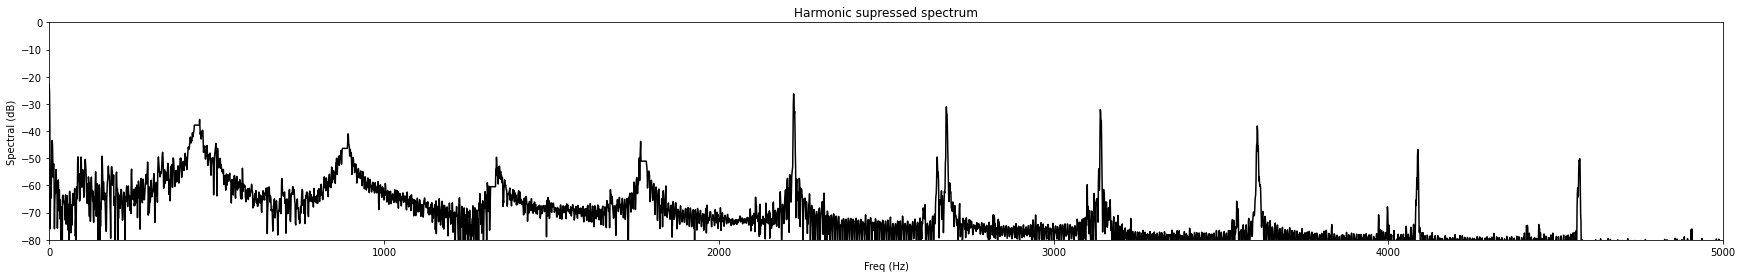

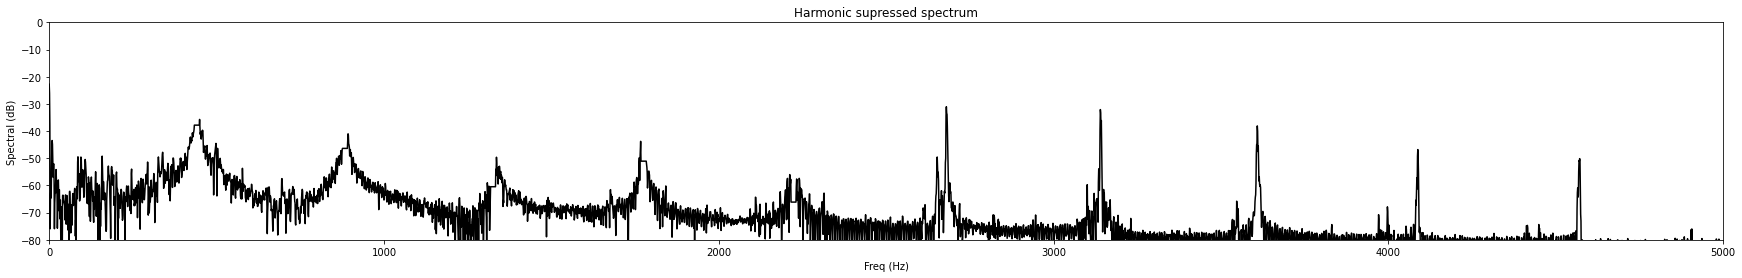

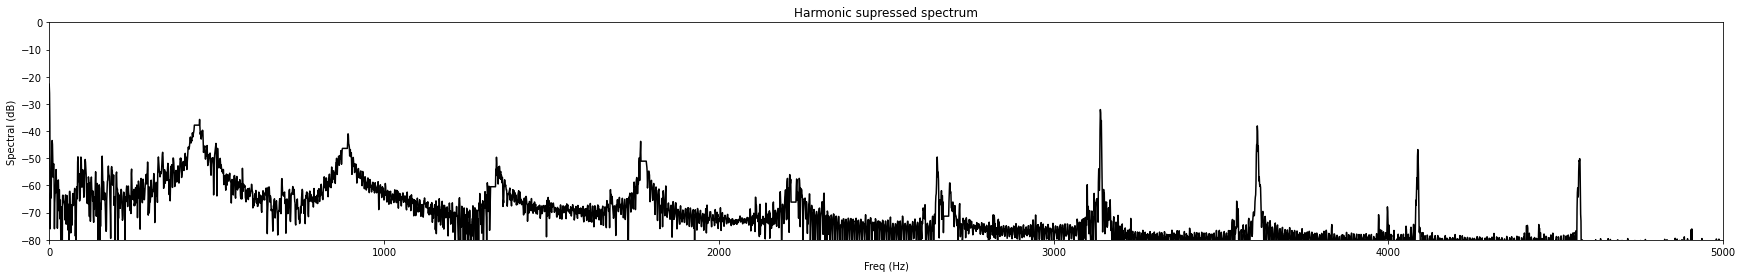

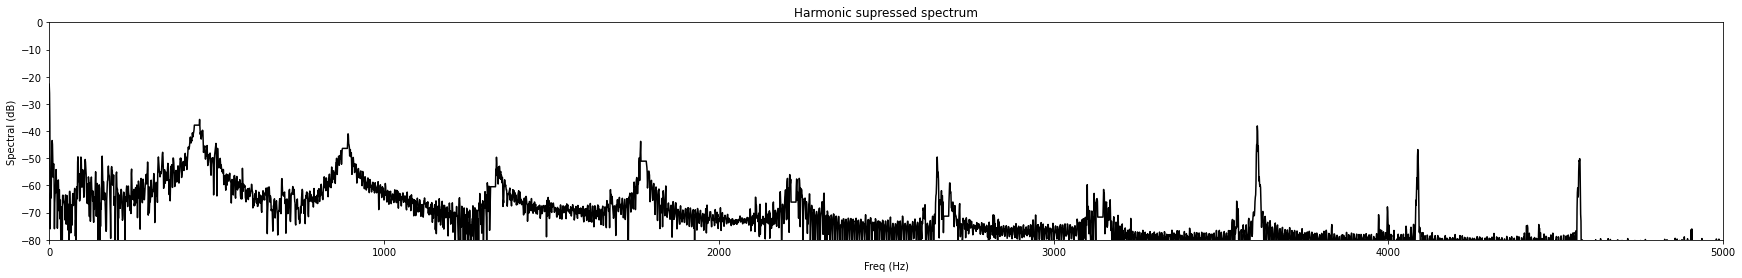

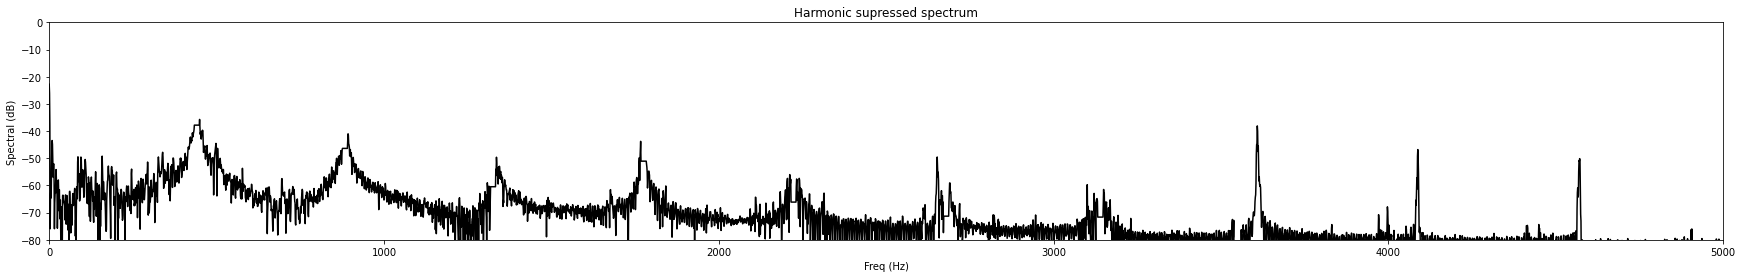

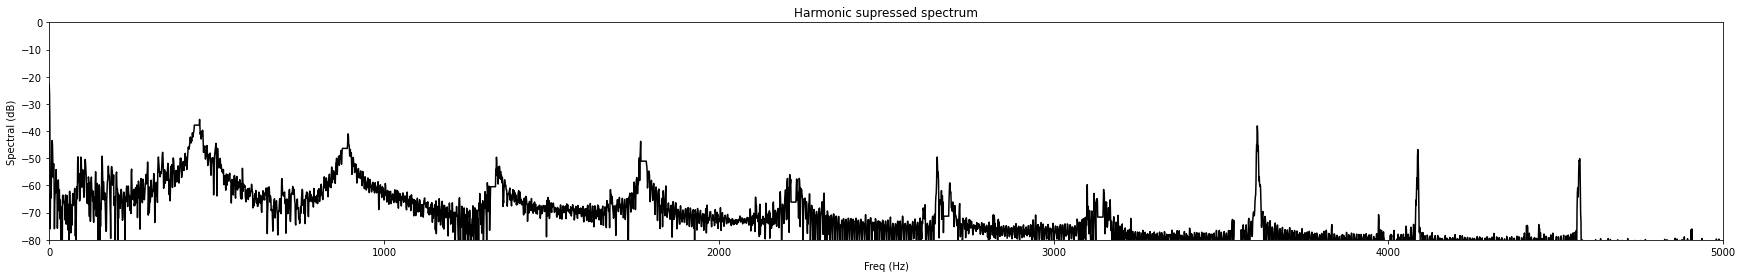

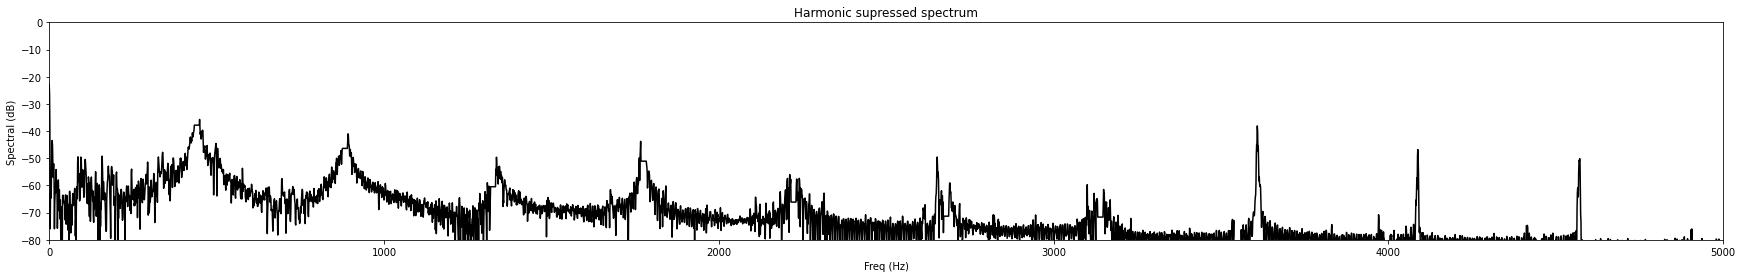

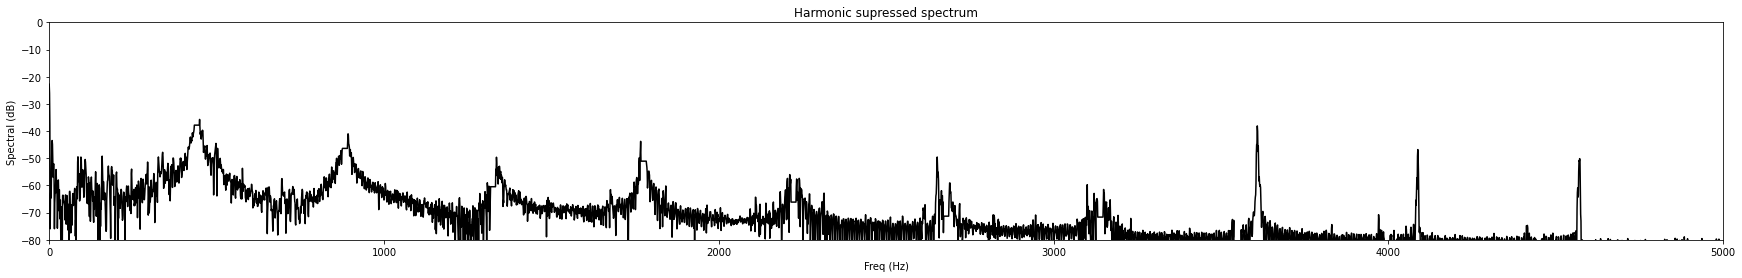

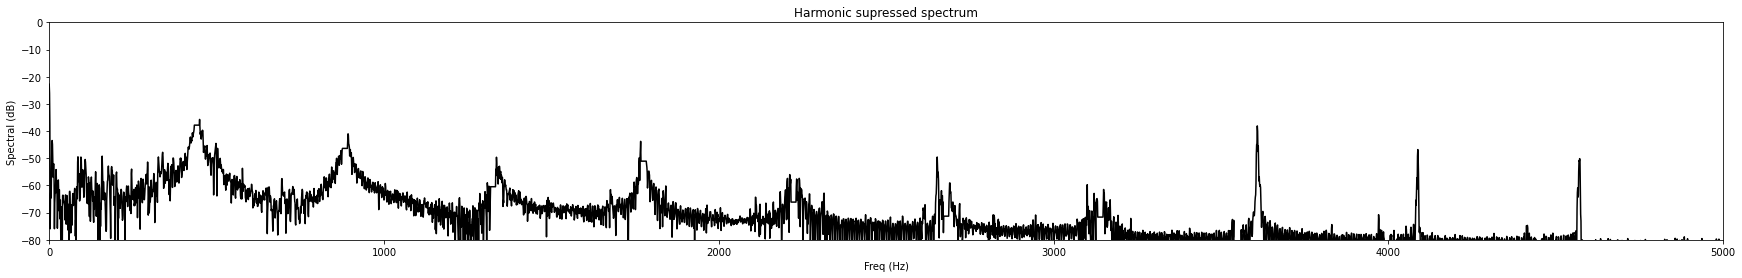

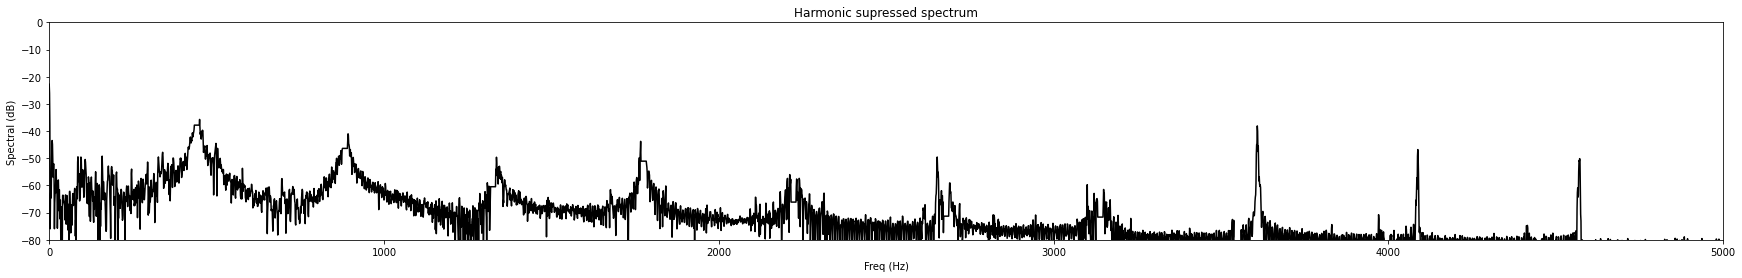

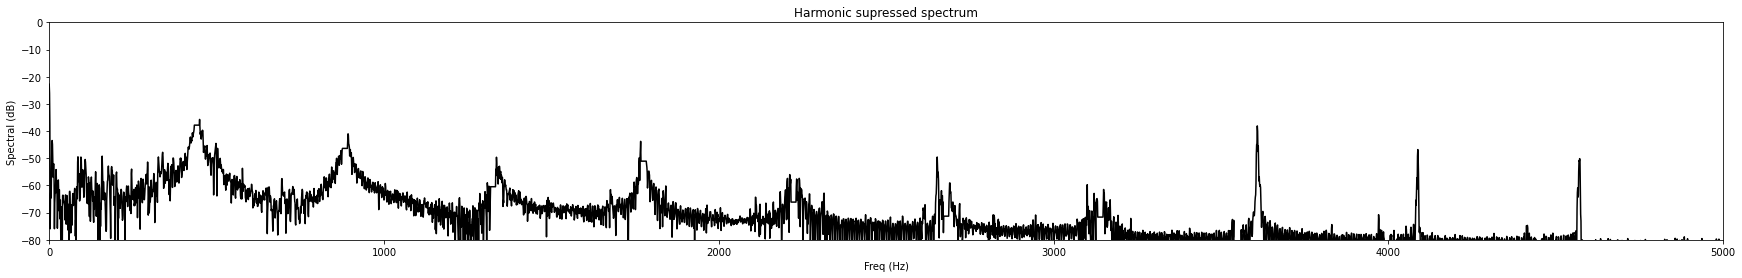

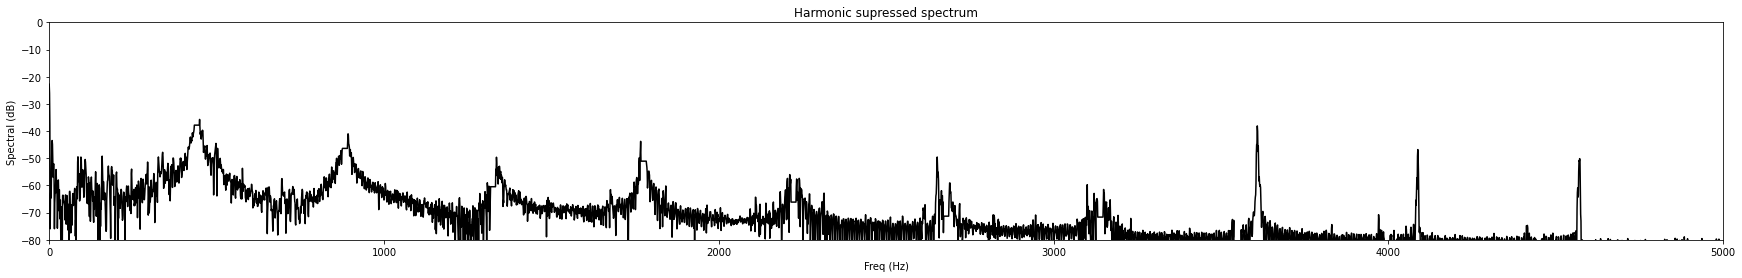

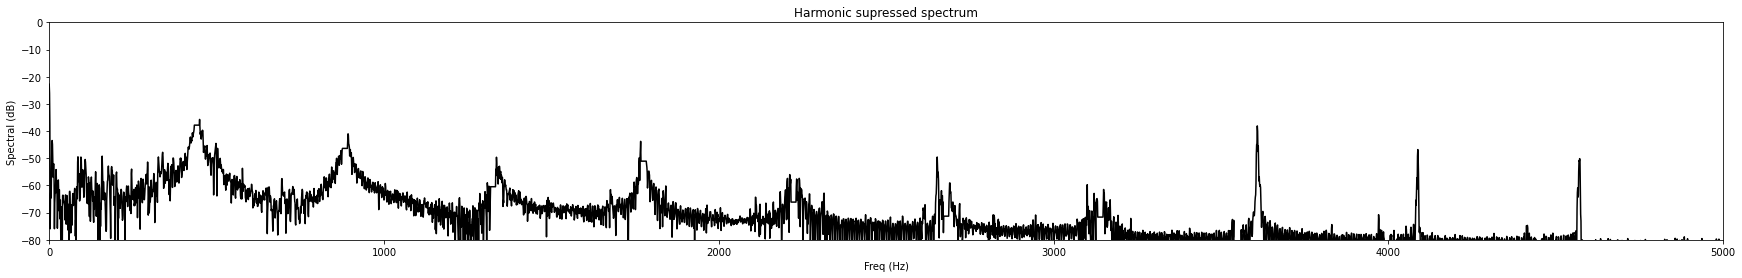

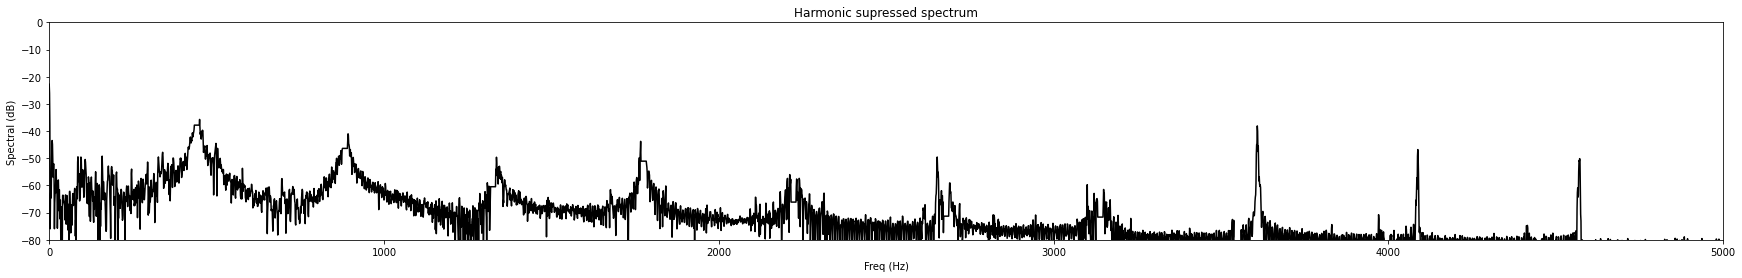

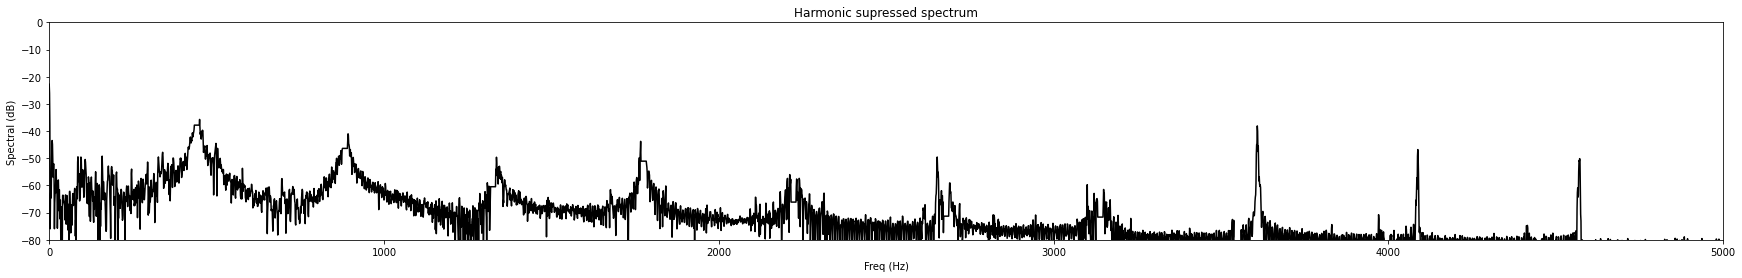

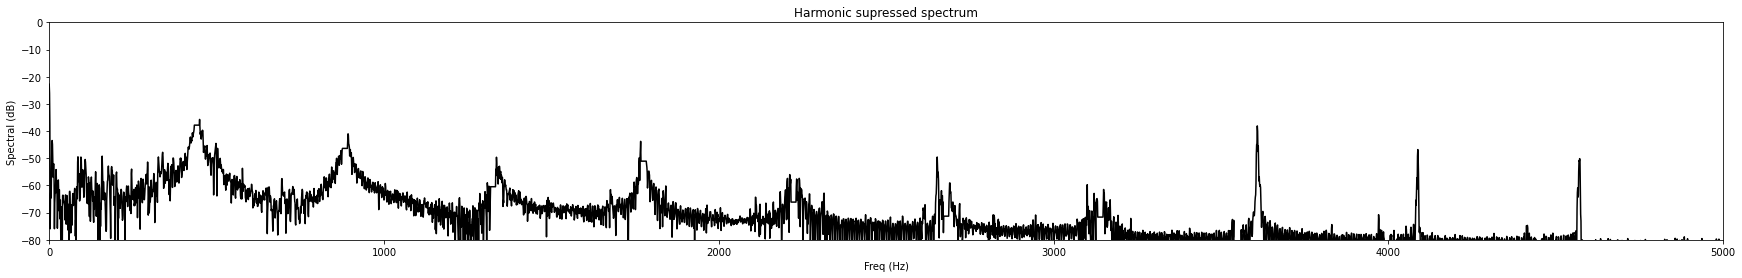

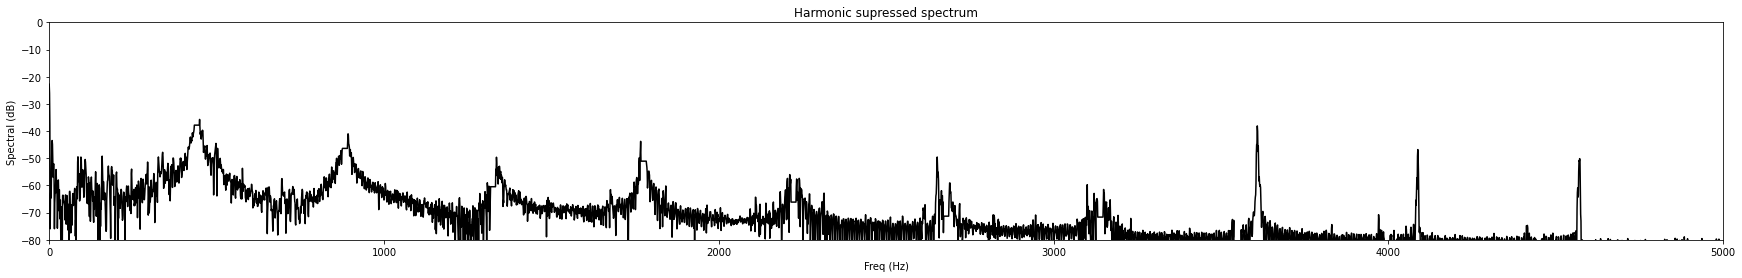

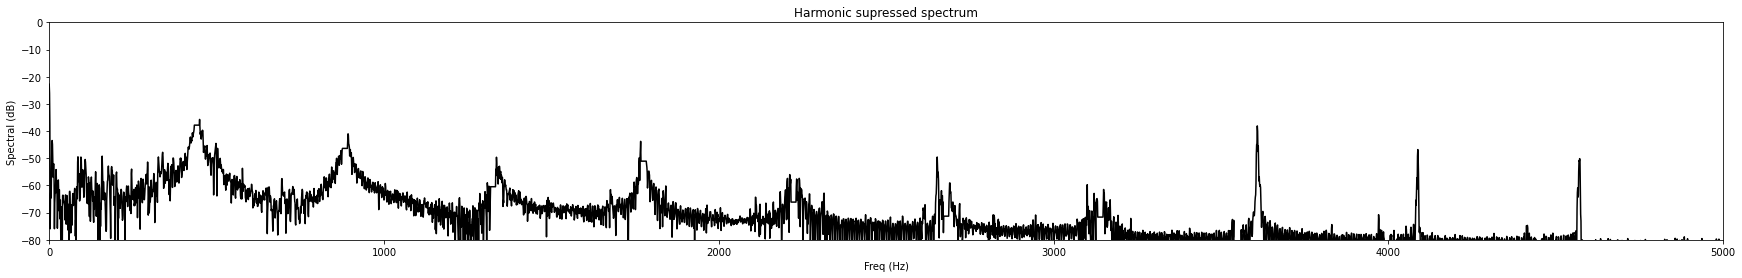

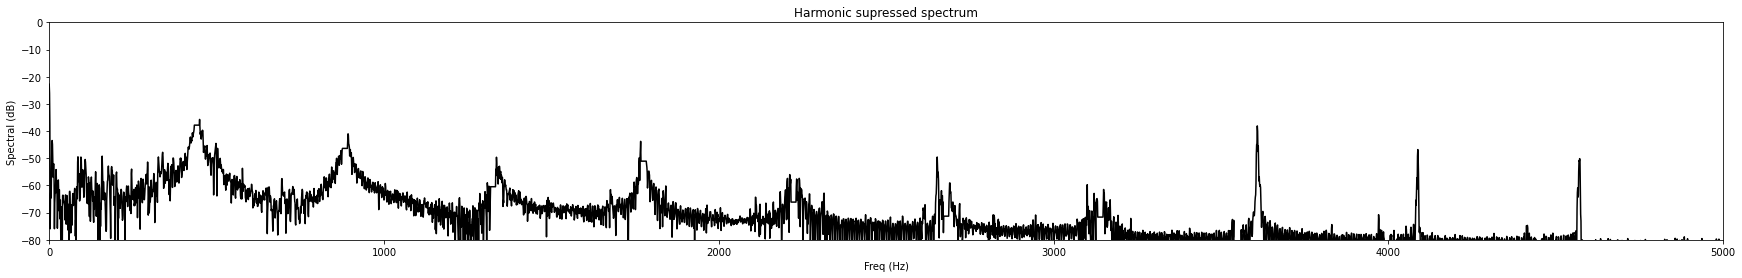

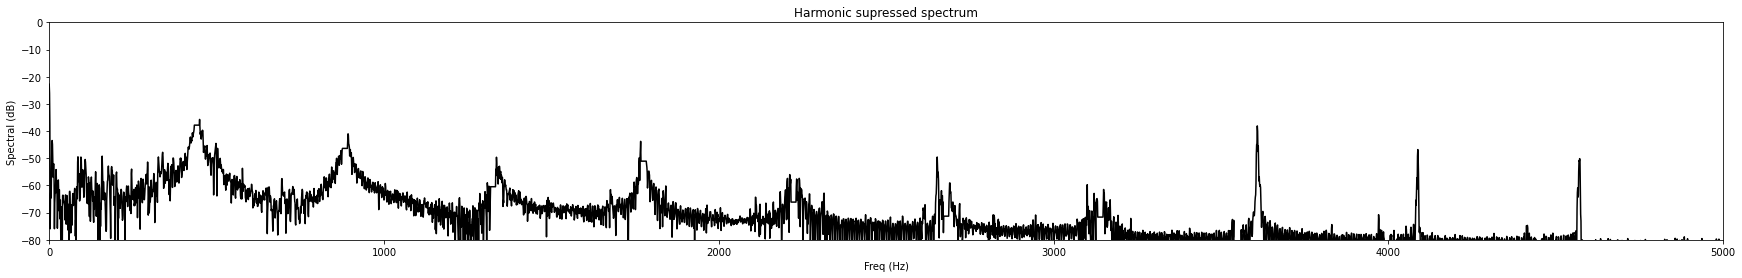

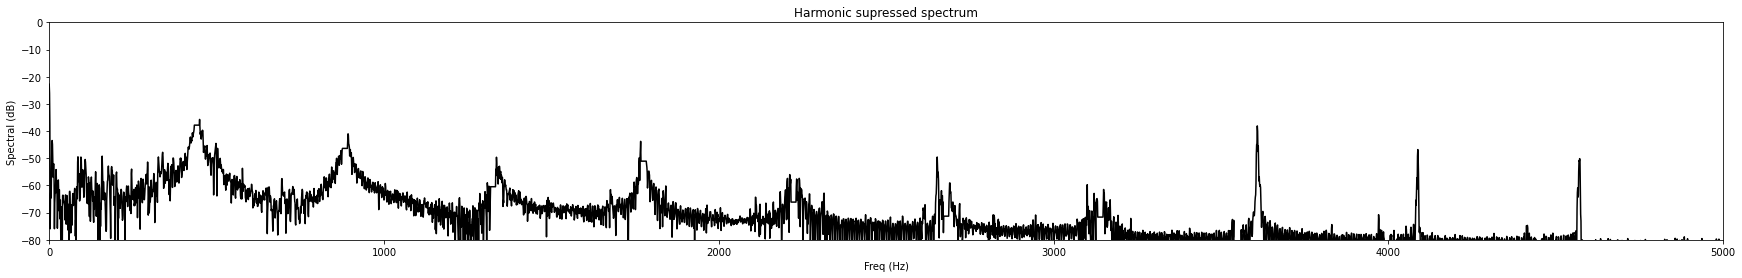

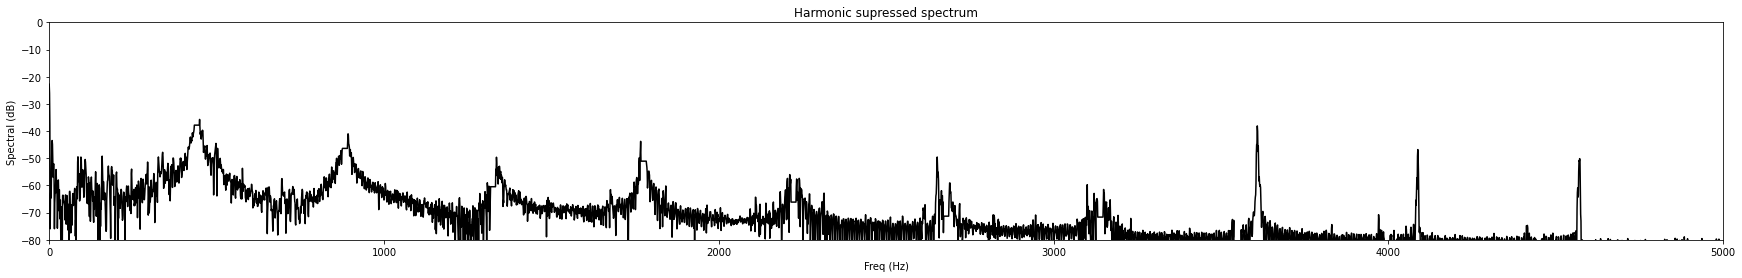

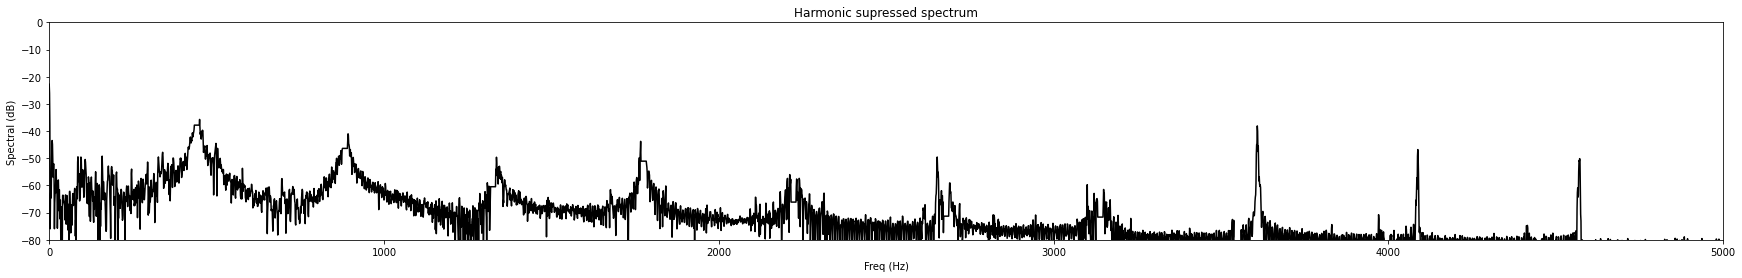

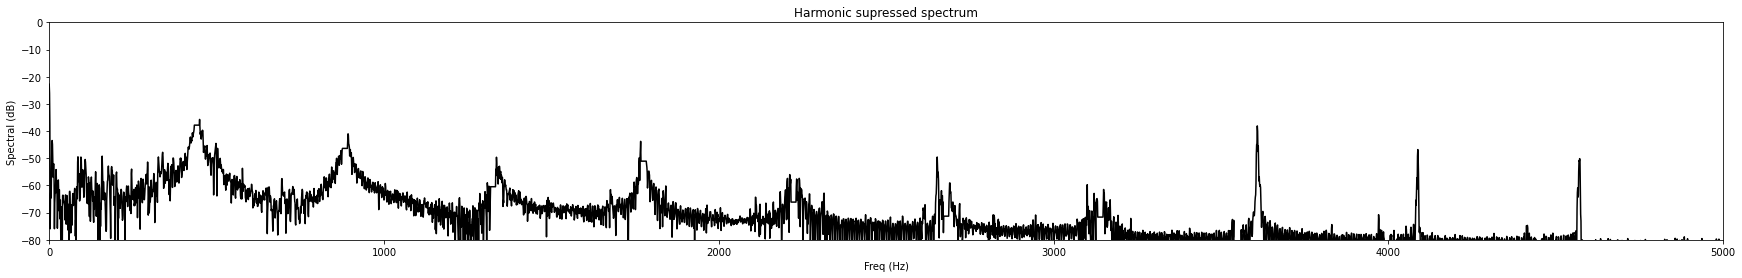

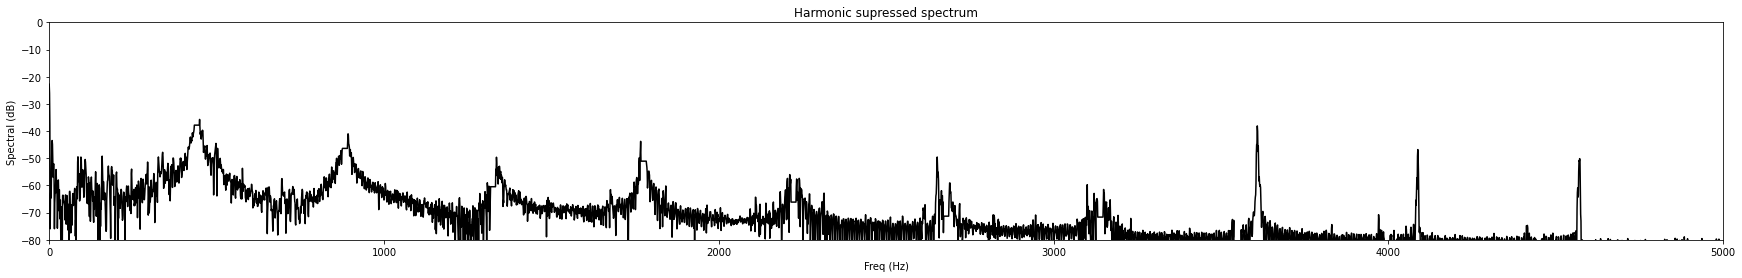

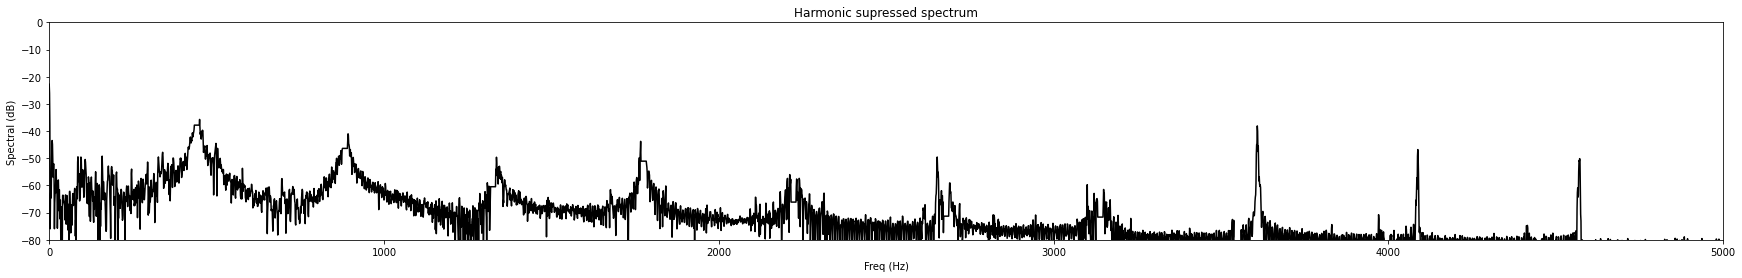

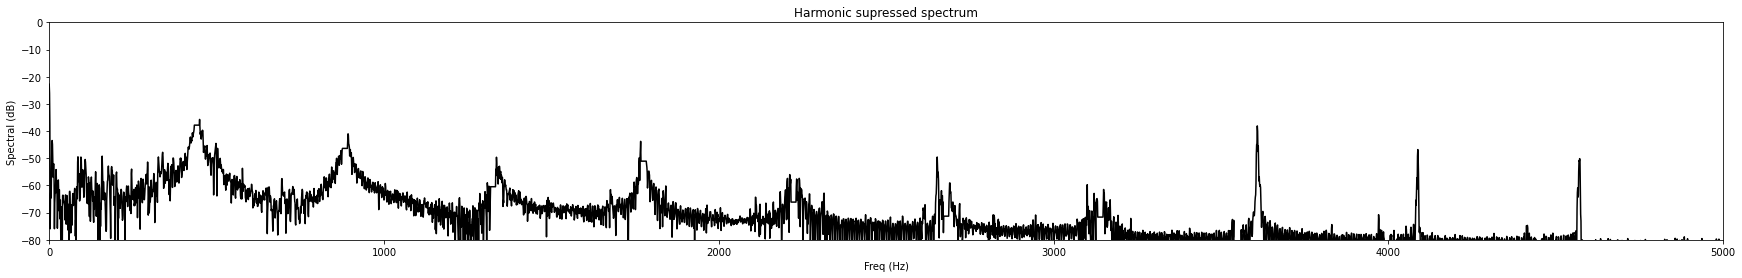

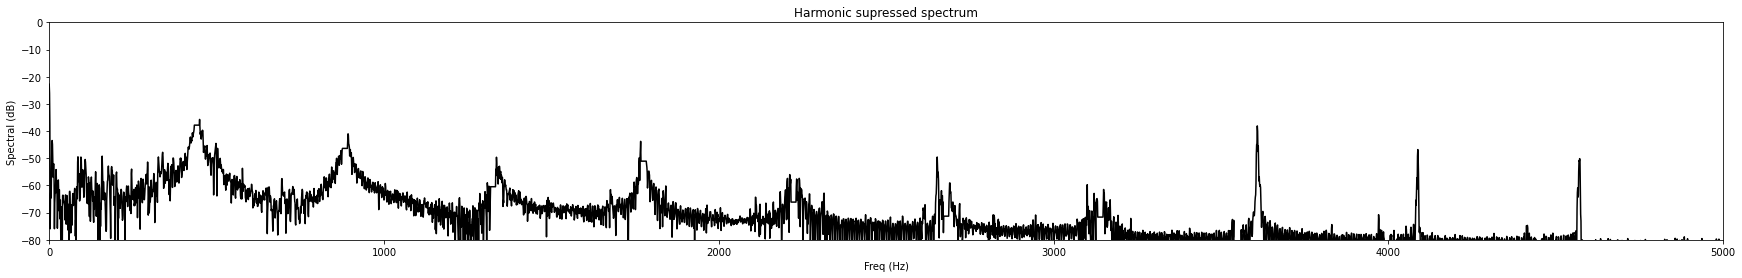

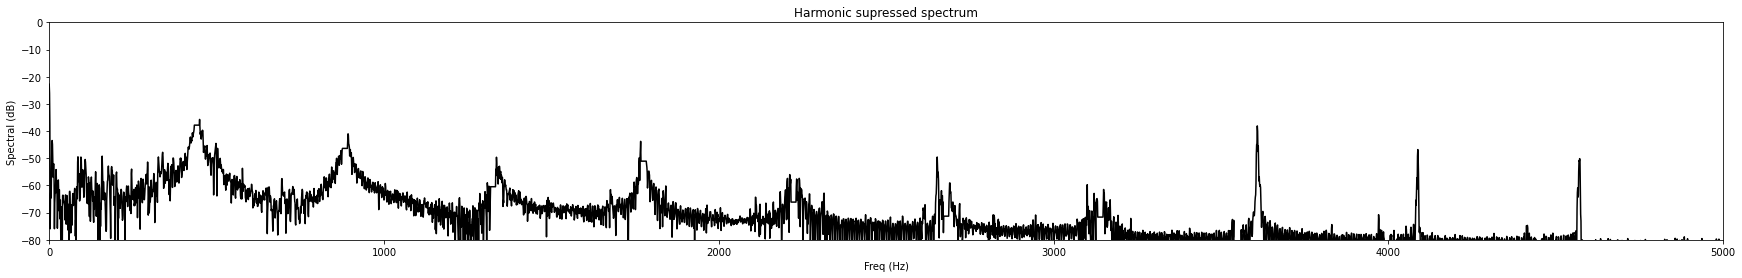

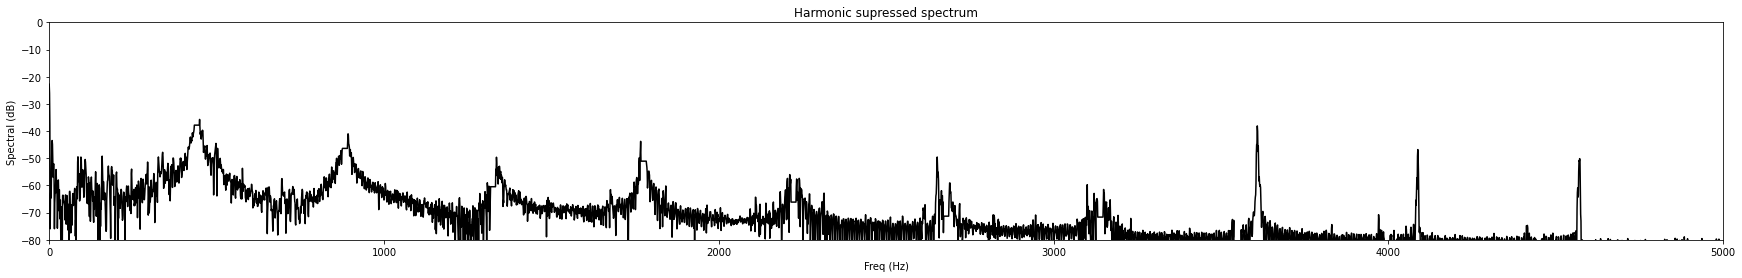

In [175]:
fr, fou = note_supression(freq, fourier, idx_f0, f0, width, plot=True)

### 4. Stopping criterion

Now we will operate our algorithm in total. 
The main idea of the algorithm is to find iteratively each fundamental frequency, then supress all its harmonics, and then go for the next fundamental frequency.
We will choose our stopping criterion if in our query field we don't observe any peak more than -25db. This criterion works well with our database.

In [176]:
def read_sound_and_info(filename):
    music = os.path.join(data_path, filename)
    wavefile = load_music(music)
    Fs = int(wavefile.getframerate())
    num_samples = int(wavefile.getnframes())
    data = wavefile.readframes(num_samples)
    data = struct.unpack('{n}h'.format(n=num_samples), data)
    x = np.array(data)
    N=ceil(0.7*Fs)       # Window size of analysed signal (only one window of signal is analysed)
    dF_min=Fs/N
    w=np.hamming(N)  # Window
    width = 4*dF_min # largeur du pic spectral (en Hz) 4*dF_min
    eps=float(1e-20)   #precision
    offset=ceil(0.1*Fs)
    xw=x[offset:offset+N]*w    # xw is the analysed signal frame
    n_xw = xw.size
    #Minimal number of data points to satisfy the minimal frequency resolution
    Nfft_min=Fs/dF_min

    #compute the smallest power of two that satisfies the minimal frequency resolution for FFT
    p, Nfft = nextpow2(Nfft_min)
    x_fft = np.fft.fft(xw, n=Nfft) #calcul FFT
    x_fft /= np.max(np.abs(x_fft))+eps # Normalization

    df=Fs/Nfft # frequency virtual resolution of FFT 
    frequencies = np.arange(Nfft)*df  # equivalent to np.fft.fftfreq(n=Nfft, d=timestep)
    X_fft = np.abs(x_fft) # absolute value of FFT (phase doesn't play a role)
    freq = frequencies[:int(Nfft/2)]
    fourier = 20*np.log10(X_fft[:int(Nfft/2)])

    return freq, fourier, Nfft, width

In [177]:
def pitch_detection(filename, plot=False):
    freq, fourier, Nfft, width,= read_sound_and_info(filename)

    Fmin = 100    # Minimal F0 frequency that can be detected
    Fmax = 900    # Maximal F0 frequency that can be detected
    H = 4
    R = 4096
    
    ind_min = len(freq[freq<Fmin])
    ind_max = len(freq[freq<Fmax])
    
    notes_found = []
    
    while np.max(fourier[ind_min:ind_max]) > -25: # Stopping criterion
        f0, idx_f0 = get_F0(freq, spectral_method(fourier, Rmax, H, method='product'), H, Rmax, Fmin, Fmax, method="product", plot=False)
        notes_found.append(f0)
        print("Fundamental frequencies found (Hz):", notes_found)
        fr, fo = harmonic_supression(freq, fourier, idx_f0, width, plot=False)
        freq, fourier = note_supression(fr, fo, idx_f0, f0, width, plot=False)

        plt.figure(figsize=(30, 4))
        plt.plot(freq, fourier, color='k')
        plt.xlim(0, 5000)
        plt.ylim(-80, 0)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Spectral (dB)')
        plt.title('Spectrum after note supression')
        plt.show()
        
    print("Notes detected in this sound:", notes_found)
    return

### 5. Test on our dataset.

Fundamental frequencies found (Hz): [888.671875]


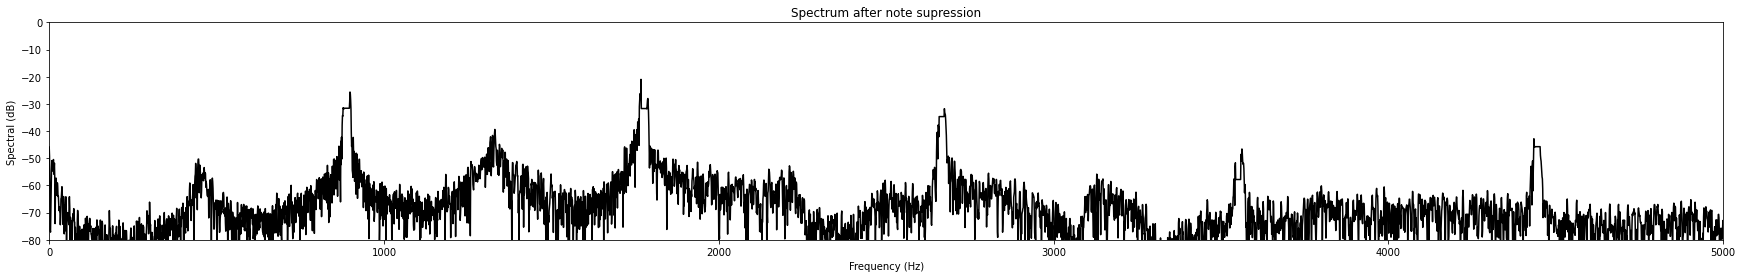

Notes detected in this sound: [888.671875]


In [178]:
pitch_detection("A5_flute.wav", plot=False)

Our algo works well with this sound.

Fundamental frequencies found (Hz): [888.671875]


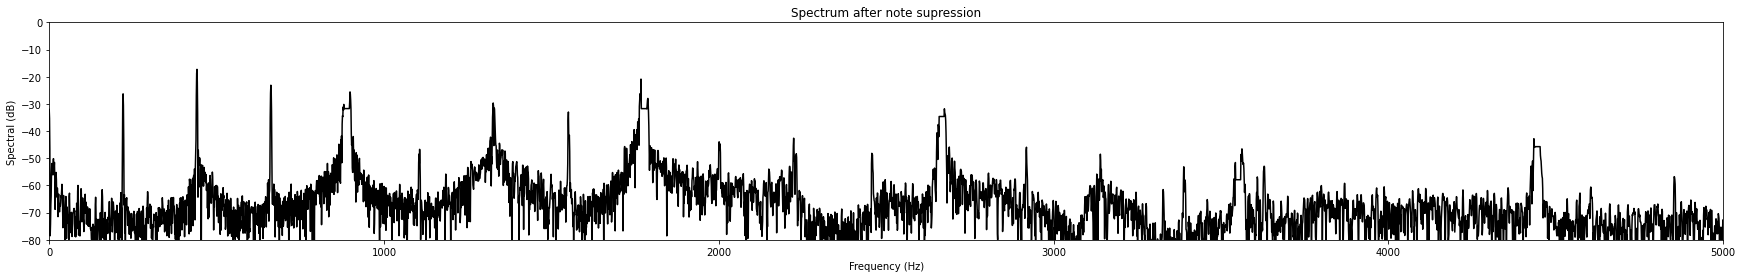

Fundamental frequencies found (Hz): [888.671875, 220.703125]


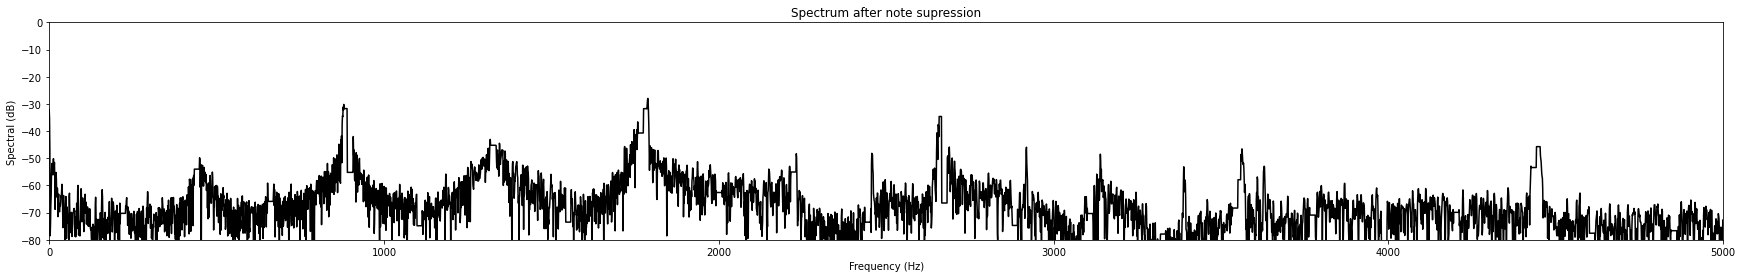

Notes detected in this sound: [888.671875, 220.703125]


In [179]:
pitch_detection("A3A4A5_duo.wav", plot=False)

### We can observe that our algo cannot detect note A4 in this sound. Because in this sound, the amplitude of A4 is smaller than our criterion (-25db) as in the graph.

Fundamental frequencies found (Hz): [261.71875]


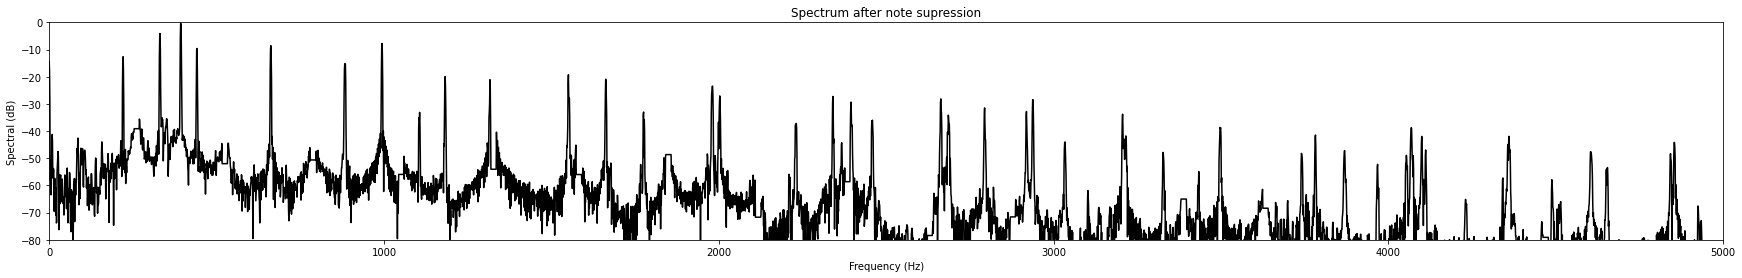

Fundamental frequencies found (Hz): [261.71875, 331.0546875]


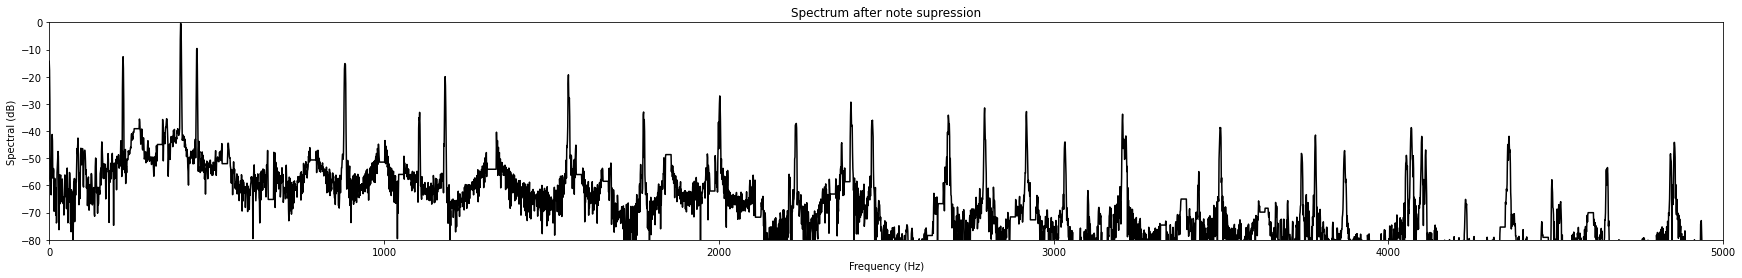

Fundamental frequencies found (Hz): [261.71875, 331.0546875, 393.5546875]


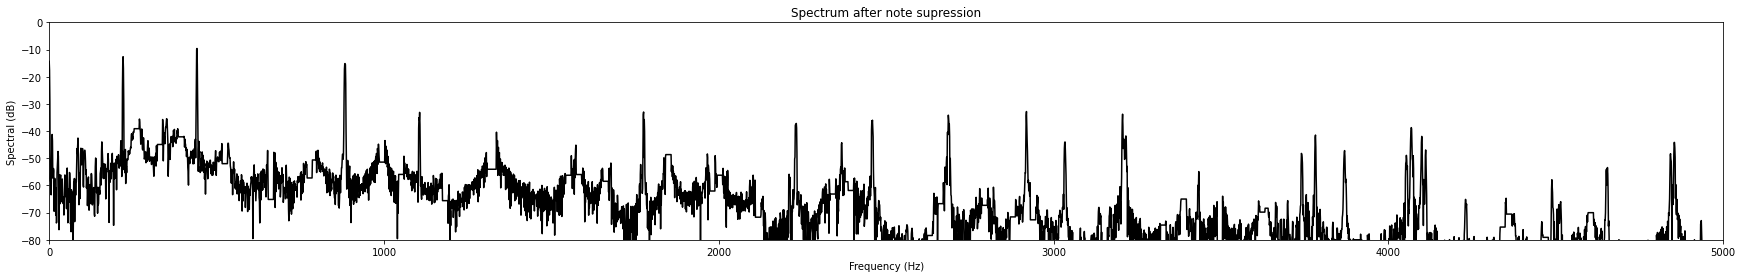

Fundamental frequencies found (Hz): [261.71875, 331.0546875, 393.5546875, 220.703125]


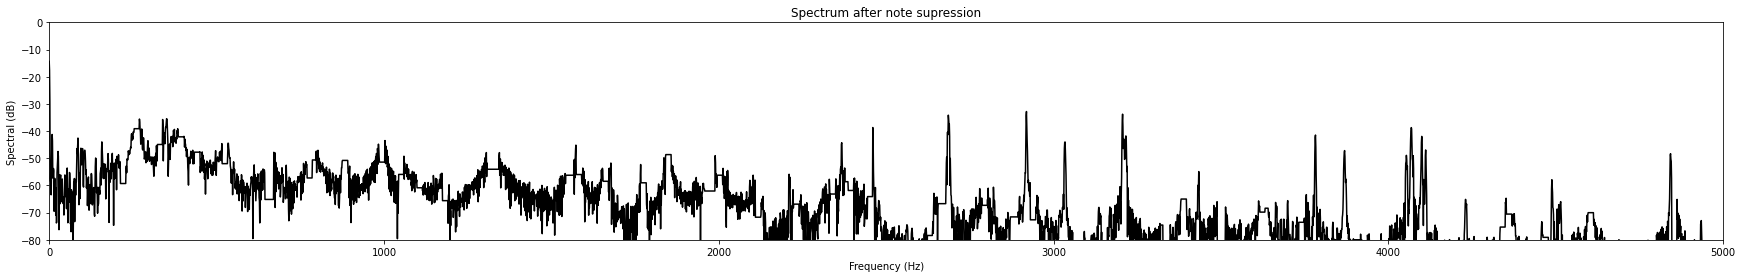

Notes detected in this sound: [261.71875, 331.0546875, 393.5546875, 220.703125]


In [180]:
pitch_detection("A3C4E4G4_piano.wav", plot=False)

Our algo works well with this sound.